<a href="https://www.kaggle.com/code/entropapi/5-class-object-detection?scriptVersionId=168359459" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pathlib
import shutil

# Adjust the path to your dataset on Kaggle
data_dir_path = "/kaggle/input/object-database/train"
data_dir = pathlib.Path(data_dir_path)

# List all image files in the directory
image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

3646


In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

/kaggle/input/object-database/train/Train 2835.jpg


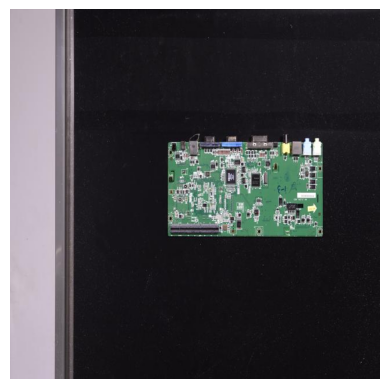

In [3]:
sample_img_path = str(image_files[103])
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [4]:
sample_annotation_path = sample_img_path[0:-4] + '.txt'
with open(sample_annotation_path) as f:
    print(f.readlines())

['4 0.63984375 0.48515625 0.4390625 0.28671875']


In [5]:
import os
import shutil
import re

# Define the source and destination directories
src_dir = '/kaggle/input/object-database/train'
dest_dir = '/kaggle/working/train'

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Regular expression pattern to match the desired annotation format
pattern = re.compile(r'^\d{1} \d+\.\d+ \d+\.\d+ \d+\.\d+ \d+\.\d+$')

# Iterate over each annotation file in the source directory
for annotation_file in os.listdir(src_dir):
    if annotation_file.endswith('.txt'):
        annotation_path = os.path.join(src_dir, annotation_file)
        
        # Read the annotation file
        with open(annotation_path, 'r') as file:
            lines = file.readlines()
        
        # Check if the annotation matches the desired format
        for line in lines:
            if pattern.match(line.strip()):
                # If the annotation matches, copy the annotation file to the destination directory
                shutil.copy(annotation_path, dest_dir)
                
                # Construct the path to the corresponding image file
                image_file = annotation_file.replace('.txt', '.jpg') # Adjust the extension as needed
                image_path = os.path.join(src_dir, image_file)
                
                # Check if the image file exists and copy it to the destination directory
                if os.path.exists(image_path):
                    shutil.copy(image_path, dest_dir)
                break # No need to check the rest of the lines if one matches


In [6]:
import os

# Define the directory containing your text files
directory = '/kaggle/working/train'

# List all files in the directory
all_files = os.listdir(directory)

# Filter only text files
txt_files = [file for file in all_files if file.endswith('.txt')]

# Ensure there are at least 5 text files
if len(txt_files) < 5:
    print("There are less than 5 text files in the directory.")
else:
    # Read the first 5 text files
    for i in range(5):
        file_path = os.path.join(directory, txt_files[i])
        with open(file_path, 'r') as file:
            content = file.read()
            print(f"Content of {txt_files[i]}:")
            print(content)
            print("---")

Content of Train 2416.txt:
4 0.5203125 0.47890625 0.26015625 0.78671875
---
Content of Train 83.txt:
3 0.128125 0.56015625 0.1453125 0.44609375
3 0.39609375 0.57578125 0.1421875 0.45859375
3 0.64296875 0.5671875 0.13984375 0.428125
3 0.88203125 0.5625 0.146875 0.45390625
---
Content of Train 1591.txt:
1 0.5640625 0.16640625 0.1359375 0.24375
1 0.48177896562500006 0.6363510765625 0.5673209609375001 0.82351854375 0.6239274781249999 0.8767172375 0.7029727703125 0.780497203125 0.6594653828125 0.6445932890625 0.5459143796875 0.57131728125 0.4797465609375 0.6327160390625 0.48177896562500006 0.6363510765625
---
Content of Train 126.txt:
3 0.29375 0.50546875 0.196875 0.4734375
---
Content of Train 1198.txt:
3 0.44921875 0.44609375 0.7546875 0.671875
---


In [7]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation=cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

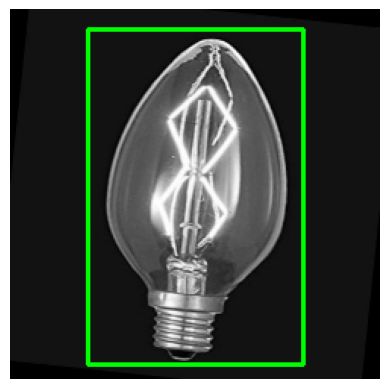

In [8]:
temp_img = cv.imread("/kaggle/working/train/Train 193.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.50546875, 0.51015625, 0.5890625, 0.9109375]

temp_img_formated, box = format_image(temp_img, temp_box)
temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

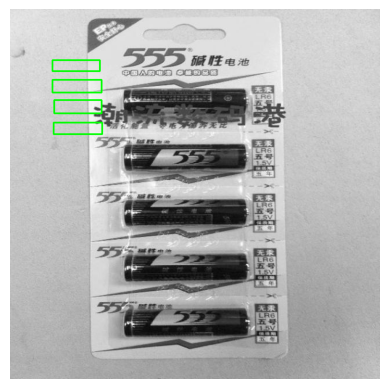

In [9]:
temp_img = cv.imread("/kaggle/working/train/Train 769.jpg", cv.IMREAD_GRAYSCALE)
annotations = [
    [0.471875, 0.40078125, 0.3375, 0.078125],
    [0.475, 0.546875, 0.34921875, 0.09296875],
    [0.484375, 0.69453125, 0.33984375, 0.09453125],
    [0.4828125, 0.84453125, 0.34765625, 0.08203125]
]

# Convert the grayscale image to RGB for drawing
temp_color_img = cv.cvtColor(temp_img, cv.COLOR_GRAY2RGB)

# Draw each bounding box on the image
for box in annotations:
    temp_img_formated, new_box = format_image(temp_img, box)
    cv.rectangle(temp_color_img, (new_box[0], new_box[1]), (new_box[0] + new_box[2], new_box[1] + new_box[3]), (0, 255, 0), 2)

# Display the image with all bounding boxes
plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

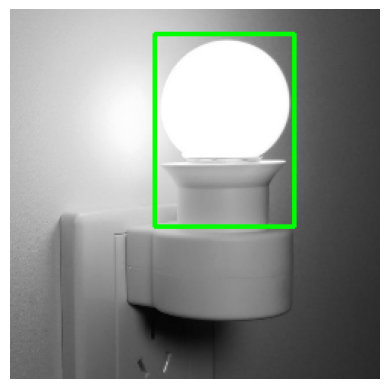

In [10]:
temp_img = cv.imread("/kaggle/input/object-database/train/Train 1003.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.58515625, 0.33203125, 0.384375, 0.525]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

In [11]:
import os

# Define the directory containing your text files
directory = '/kaggle/working/train'

# List all files in the directory
all_files = os.listdir(directory)

# Filter only text files
txt_files = [file for file in all_files if file.endswith('.txt')]

# Iterate over each text file
for txt_file in txt_files:
    file_path = os.path.join(directory, txt_file)
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # Check if the file has more than one annotation row
        if len(lines) > 1:
            # Remove the text file
            os.remove(file_path)
            # Remove the corresponding image file
            img_file = txt_file.replace('.txt', '.jpg') # Assuming images are in .jpg format
            img_path = os.path.join(directory, img_file)
            if os.path.exists(img_path):
                os.remove(img_path)

In [12]:
import os, random

def list_files(full_data_path="/kaggle/working/train", image_ext='.jpg', split_percentage=[70, 20]):
    files = []
    discarded = 0
    masked_instance = 0

    # List all files in the directory
    for file in os.listdir(full_data_path):
        if file.endswith(".txt"):
            with open(os.path.join(full_data_path, file), 'r') as fp: 
                lines = fp.readlines()
                if len(lines) > 1:
                    discarded += 1
                    continue

            strip = file[:-len(".txt")]  
            image_path = os.path.join(full_data_path, strip + image_ext)
            if os.path.isfile(image_path):
                if lines[0][0] == '0':
                    masked_instance += 1
                files.append(strip)

    size = len(files)   
    print(f"{discarded} file(s) discarded")
    print(f"{size} valid case(s)")
    print(f"{masked_instance} are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    # Adjust the split for the test set
    split_test = split_validation + int((100 - sum(split_percentage)) * size / 100)

    return files[:split_training], files[split_training:split_validation], files[split_validation:split_test]

training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

0 file(s) discarded
2262 valid case(s)
99 are masked cases
1583 training files
452 validation files
226 test files


In [13]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.__version__)

2.15.0


In [14]:
def data_load(files, full_data_path = "/kaggle/working/train", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    
    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [15]:
raw_train_ds = data_load(training_files)

In [16]:
raw_validation_ds = data_load(validation_files)

In [17]:
raw_test_ds = data_load(test_files)

In [18]:
import tensorflow as tf

CLASSES = 5 # Updated to reflect the total number of classes

def format_instance(image, label):
    # Adjust the class label to start from 0
    class_label = int(label[0]) - 1
    
    # Create one-hot encoding for the class label
    one_hot_label = tf.one_hot(class_label, CLASSES)
    
    # Extract the bounding box coordinates
    box = [label[1], label[2], label[3], label[4]]
    
    return image, (one_hot_label, box)


In [19]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [20]:
train_ds = tune_training_ds(raw_train_ds)

In [21]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [22]:
validation_ds = tune_validation_ds(raw_validation_ds)

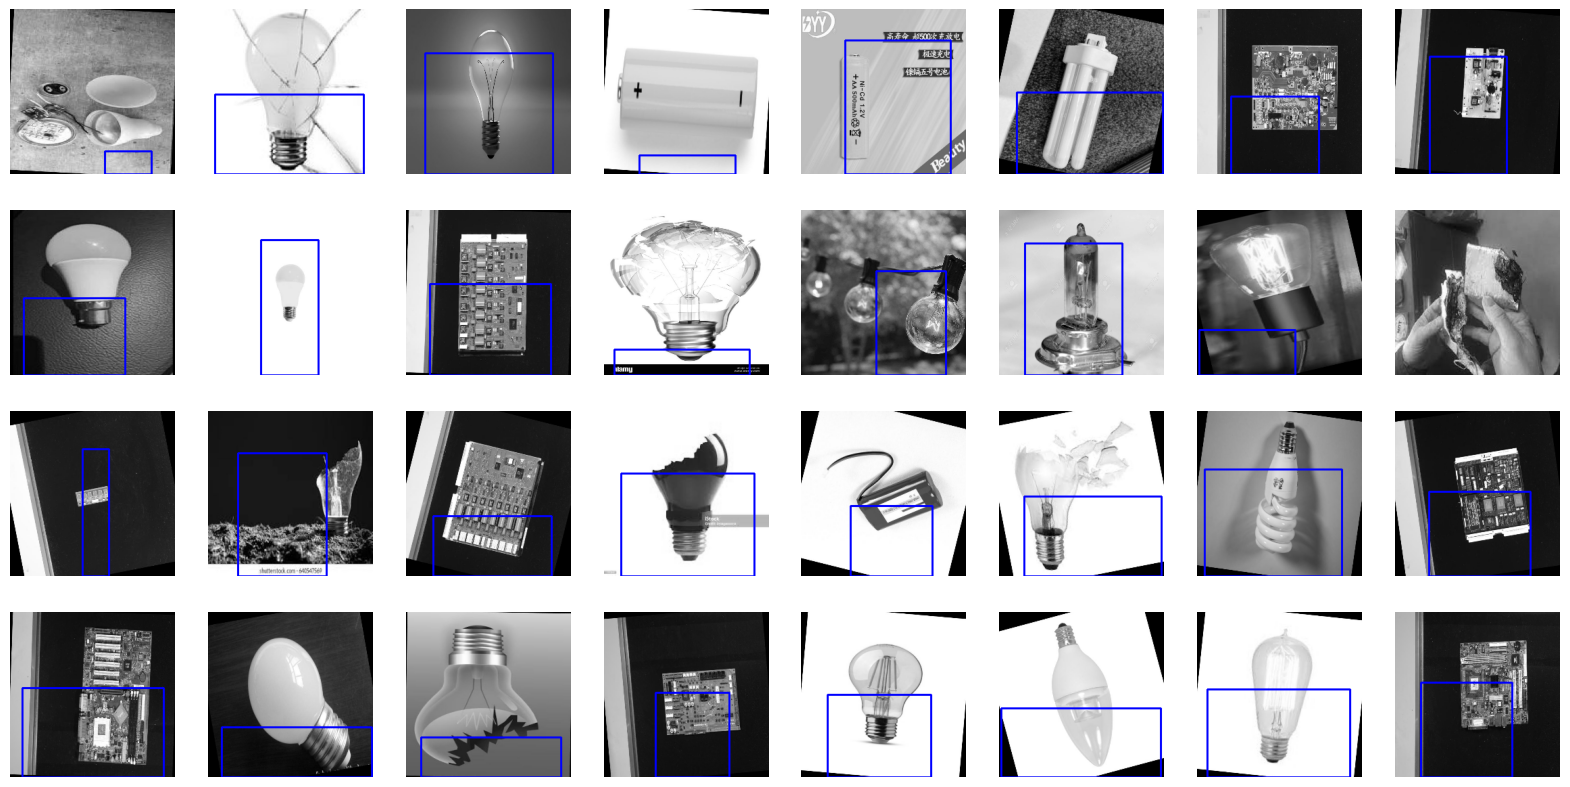

In [23]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

In [24]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units=4, name='regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [25]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 242, 242,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 121, 121,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 119, 119,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 59, 59,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 57, 57,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 57, 57,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 28, 28,    │          0 │ dropout[0][0]     │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │  3,211,328 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 5)         │        325 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_head      │ (None, 4)         │        260 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,235,209 (12.34 MB)

 Trainable params: 3,235,209 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

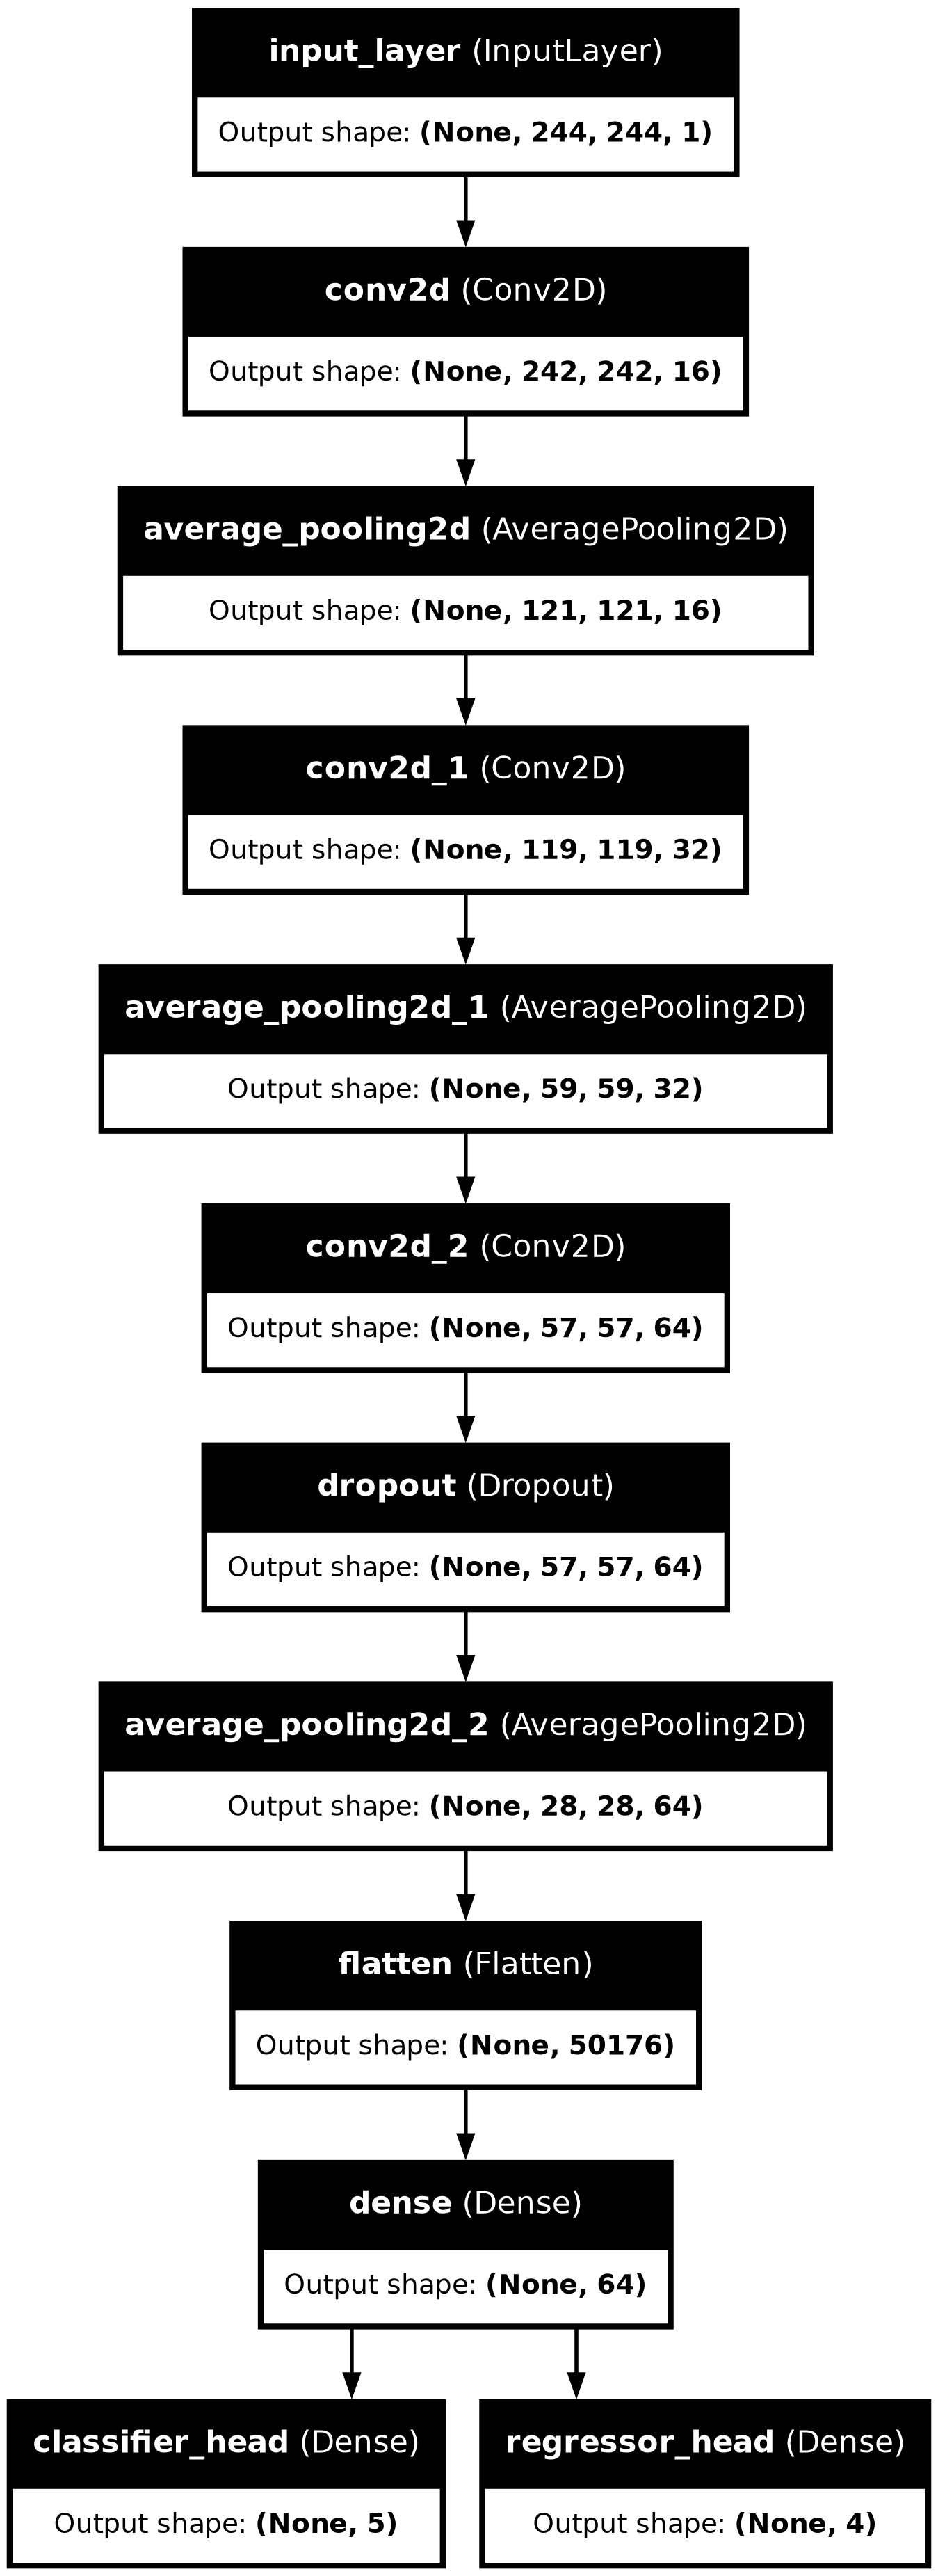

In [26]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [27]:
# Define the early stopping callback with patience set to 10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classifier_head_accuracy', # Monitor the validation accuracy
    min_delta=0, # Minimum change in the monitored quantity to qualify as an improvement
    patience=10, # Number of epochs with no improvement after which training will be stopped
    verbose=1, # Verbosity mode
    mode='max', # Whether the monitored quantity should be maximized or minimized
    baseline=None, # Baseline value for the monitored quantity
    restore_best_weights=True # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

# Define the ModelCheckpoint callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_weights.keras',
    monitor='val_classifier_head_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

EPOCHS = 10

# Train the model with the early stopping and ModelCheckpoint callbacks
history = model.fit(
    train_ds,
    steps_per_epoch=(len(training_files) // BATCH_SIZE),
    validation_data=validation_ds,
    validation_steps=1,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping, checkpoint] # Add the early stopping and ModelCheckpoint callbacks here
)


Epoch 1: val_classifier_head_accuracy improved from -inf to 0.00000, saving model to best_model_weights.keras

Epoch 2: val_classifier_head_accuracy improved from 0.00000 to 1.00000, saving model to best_model_weights.keras

Epoch 3: val_classifier_head_accuracy did not improve from 1.00000

Epoch 4: val_classifier_head_accuracy did not improve from 1.00000

Epoch 5: val_classifier_head_accuracy did not improve from 1.00000

Epoch 6: val_classifier_head_accuracy did not improve from 1.00000

Epoch 7: val_classifier_head_accuracy did not improve from 1.00000

Epoch 8: val_classifier_head_accuracy did not improve from 1.00000

Epoch 9: val_classifier_head_accuracy did not improve from 1.00000

Epoch 10: val_classifier_head_accuracy did not improve from 1.00000
Restoring model weights from the end of the best epoch: 2.


In [28]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_classifier_head_accuracy']) + 1 # +1 because epoch indexing starts at 1

# Extract the best accuracy and loss values
best_accuracy = history.history['val_classifier_head_accuracy'][best_epoch - 1]
best_loss = history.history['val_loss'][best_epoch - 1]

# Print the best accuracy and loss values
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best Loss: {best_loss:.4f}")


Best Accuracy: 1.0000
Best Loss: 211.3544


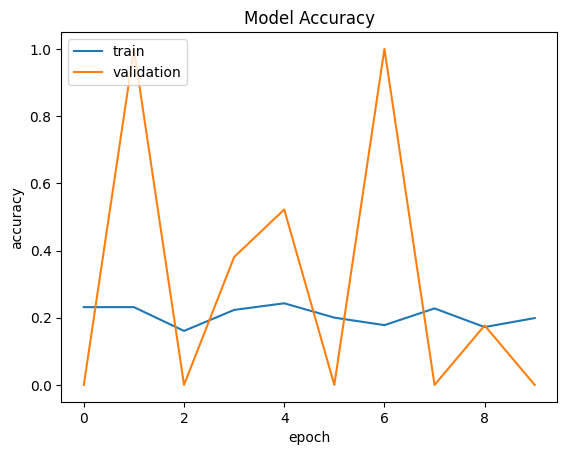

In [29]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

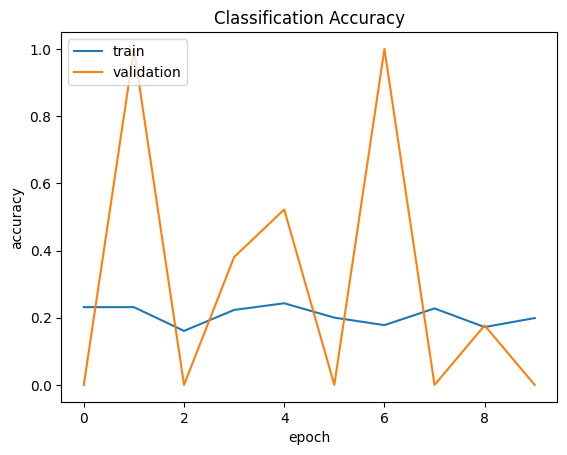

In [30]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

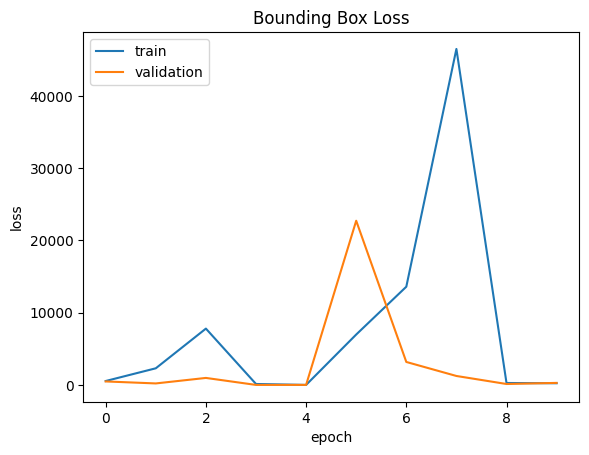

In [31]:
plt.plot(history.history['regressor_head_mse'])
plt.plot(history.history['val_regressor_head_mse'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

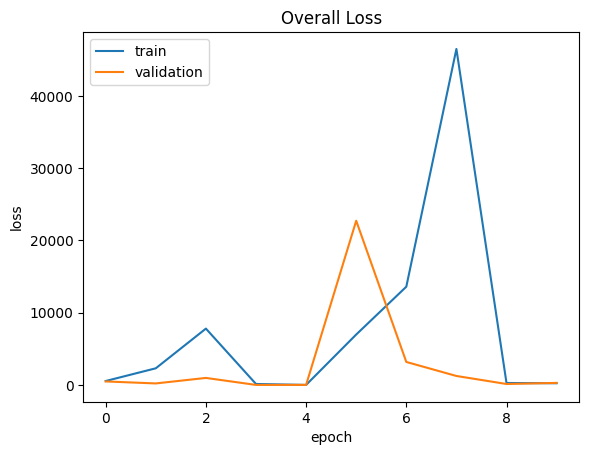

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Overall Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [34]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

20


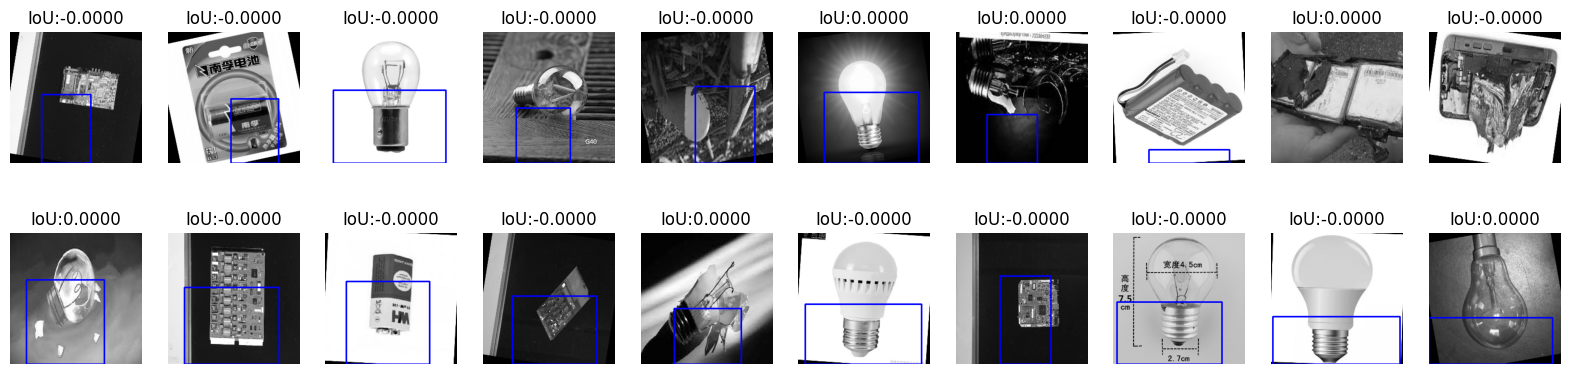

In [35]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")